In [49]:
## Packages
import pathlib
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

file_path = pathlib.Path('').parent
sys.path.insert(0, file_path)
import local_utils as lu

In [50]:
## Hyperparameters
DATA = 'cifar'
N_CLASSES = 10

N_ROUNDS = 250

DBA = 1
N_MALICIOUS = 4

NEURO = 1
NEURO_P = 0.1

ALPHA = 1
ALPHA_VAL = 10000

In [51]:
## Paths
project_path = (
    pathlib.Path().home() / 
    'Documents' /
    'TAG'
)

experiment_path = (
    project_path / 
    f'{DATA}_{N_CLASSES}' /
    ('neuro' if NEURO else 'classic') /
    'tag' /
    ('distributed' if DBA else 'centralized') /
    f'alpha{ALPHA}--alpha_val{ALPHA_VAL}'
)
experiement_suffix = f'--n_malicious{N_MALICIOUS}'

output_path = experiment_path / 'output'
if not output_path.exists():
    output_path.mkdir(parents=True)
    
subdir_path = (
    experiment_path / 
    f'n_rounds{N_ROUNDS}--d_start1--m_start1--n_malicious{N_MALICIOUS}'
)

In [52]:
## Data
val_path = (
    subdir_path /
    'data' /
    (
        'output_val_ks'
        + (f'--neuro_p{NEURO_P}' if NEURO else '')
        + '.npy'
    )
)
val_ks = np.load(val_path, allow_pickle=True)

user_path = (
    subdir_path /
    'data' /
    (
        'output_user_ks'
        + (f'--neuro_p{NEURO_P}' if NEURO else '')
        + '.npy'
    )
)
user_ks = np.load(user_path, allow_pickle=True)

id_path = (
        subdir_path /
        'data' /
        (
                'output_user'
                + (f'--neuro_p{NEURO_P}' if NEURO else '')
                + '.npy'
        )
)
user_id = np.load(id_path, allow_pickle=True)

In [53]:
## Manipulation

## Validation
# remove last validation check for terminated iteration
val_data = val_ks[:-1]

# set aside scaling header
# remove useless round information
val_data, scaling_header = val_data[1:], val_data[0, 1:]

# separate round info from class distances
# scale class distances
val_data_round, val_data_values = val_data[:, 0], val_data[:, 1:]
val_data_values *= scaling_header

# compute the defense threshold
# ensure that the threshold is not greater than 1
val_data_max = val_data_values.max(axis=1)
val_data_thresh = lu.min_mean_smooth(val_data_max, scale=2)
val_data_thresh = np.minimum(val_data_thresh, 1)

## Users
# determine if user should update the global model
user_malicious, user_round, user_values = (
    user_ks[:, 0], user_ks[:, 1], user_ks[:, 2:]
)
user_values_max = user_values.max(axis=1)
user_update = np.array([
    value <= val_data_thresh[int(r - 1)]
    for r, value in zip(user_round, user_values_max)
])

# combine user data as a dataframe
# ensure that user data is the same, combine user id
user_data = pd.DataFrame({
    'malicious': user_malicious,
    'round': user_round,
    'update': user_update,
})

assert np.equal(user_data['malicious'].values, user_id[:, 0]).all()
assert np.equal(user_data['round'].values, user_id[:, 1]).all()
user_data['id'] = user_id[:, 2]

C:\Users\joela\AppData\Local\Temp\ipykernel_29792\2746145153.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heat_data = heat_data.replace({False: 0, True: 1})


<Axes: xlabel='round', ylabel='id'>

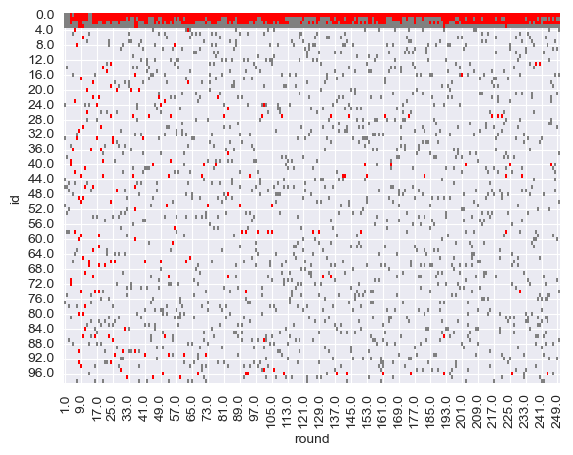

In [54]:
## Heatmap 
heat_data = user_data.pivot(
    index='id',
    columns='round',
    values='update'
)

cmap = sns.color_palette(['red', 'blue', 'grey'])
heat_data = heat_data.replace({False: 0, True: 1})

sns.heatmap(heat_data, cmap=cmap, cbar=False)